In [1]:
import pandas as pd
import numpy as np
import os
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    cohen_kappa_score,
    matthews_corrcoef
)



import matplotlib.pyplot as plt

In [2]:
# Set working directory
os.chdir("/Users/vanessazepeda/Documents/machine_learning/Wine-Quality")

In [3]:
# Load in dataset
df = pd.read_csv("Data/wine_df.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Constructing labels: multiclass (3-class) setup 
def make_labels(y_quality: np.ndarray, mode: str = "3class"):
    """
    Convert original wine quality scores into 3-class labels
    
    3-class mapping: 
        0 = low quality (<=5)
        1 = medium quality (=6)
        2 = high quality (>=7)
    """
    yq = pd.Series(y_quality).astype(int).to_numpy()
    
    y = np.where(yq <= 5, 0,
                np.where(yq == 6, 1, 2))
    class_names = ["low(<=5)", "mid(=6)", "high(>=7)"]
    
    return y, class_names


y, class_names = make_labels(df["quality"].to_numpy())
X = df.drop(columns=["quality"])

print("Class distribution (0=low, 1=mid, 2=high):")
print(pd.Series(y).value_counts().sort_index())
print("Class names:", class_names)

Class distribution (0=low, 1=mid, 2=high):
0    744
1    638
2    217
Name: count, dtype: int64
Class names: ['low(<=5)', 'mid(=6)', 'high(>=7)']


In [5]:
# Train / test split 
"""
Stratification preserves class imbalance proportions
"""
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)

In [6]:
train_df = X_train.copy()
train_df["target"] = y_train

dfs = {
    cls: train_df[train_df["target"] == cls]
    for cls in np.unique(y_train)
}

max_size = max(len(df) for df in dfs.values())

resampled_dfs = [
    resample(df,
            replace=True,
            n_samples=max_size,
            random_state=42)
    for df in dfs.values()
]
train_balanced = pd.concat(resampled_dfs)

X_train_bal = train_balanced.drop(columns="target")
y_train_bal = train_balanced["target"]

In [7]:
# Baseline ANN Pipeline
ann_baseline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    
    # Simple ANN with one hidden layer 
    ("mlp", MLPClassifier(
    hidden_layer_sizes= (50,),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
    ))
])

# Train baseline model
ann_baseline.fit(
    X_train_bal,
    y_train_bal,
)

# Predict on test set
y_pred_baseline = ann_baseline.predict(X_test)

/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
# Tuned ANN
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate_init": [0.001, 0.01],
}

ann_tuned = GridSearchCV(
    estimator = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
        activation = "relu",
        solver = "adam",
        max_iter=500, random_state=42,
        ))
    ]),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

# Train tuned model
ann_tuned.fit(X_train_bal,y_train_bal)

# Predict using best tuned_model
y_pred_tuned = ann_tuned.predict(X_test)

/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vanessazepeda/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [9]:
best_params = ann_tuned.best_params_
with open("/Users/vanessazepeda/Documents/machine_learning/Wine-Quality/Models/ANN/ann_tuned_results/best_hyperparameters.json", "w") as f:
    json.dump(best_params, f, indent=4)
    
    

In [10]:
# Model evaluation
# Baseline
cm_base = confusion_matrix(y_test, y_pred_baseline, normalize='true')

metrics = {}

metrics["classification_report"] = classification_report(
    y_test,
    y_pred_baseline,
    target_names=class_names,
    output_dict=True
)

metrics["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred_baseline)
metrics["cohen_kappa"] = cohen_kappa_score(y_test, y_pred_baseline)
metrics["mcc"] = matthews_corrcoef(y_test, y_pred_baseline)

with open("/Users/vanessazepeda/Documents/machine_learning/Wine-Quality/Models/ANN/ann_base_results/baseline_evaluation_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)


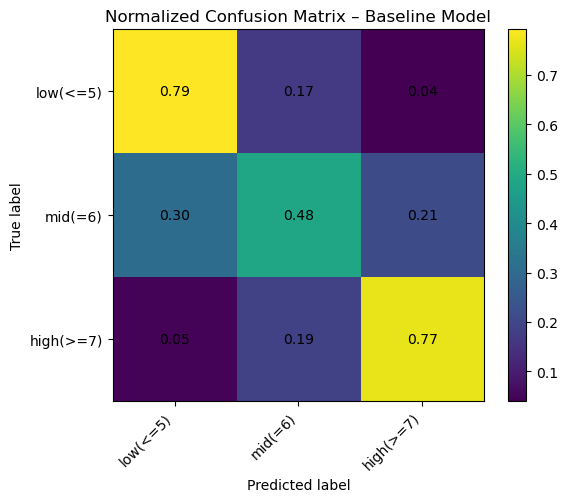

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_base)

# Add colorbar
plt.colorbar(im, ax=ax)

# Axis labels
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Normalized Confusion Matrix – Baseline Model"
)

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate cells
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{cm_base[i, j]:.2f}",
                ha="center", va="center")

plt.tight_layout()
plt.savefig("/Users/vanessazepeda/Documents/machine_learning/Wine-Quality/Models/ANN/ann_base_results/base_confusion_matrix.png", dpi=300)
plt.show()

In [12]:
# Tuned
cm_tune = confusion_matrix(y_test, y_pred_tuned, normalize='true')


metrics = {}

metrics["classification_report"] = classification_report(
    y_test,
    y_pred_tuned,
    target_names=class_names,
    output_dict=True
)

metrics["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred_tuned)
metrics["cohen_kappa"] = cohen_kappa_score(y_test, y_pred_tuned)
metrics["mcc"] = matthews_corrcoef(y_test, y_pred_tuned)

with open("/Users/vanessazepeda/Documents/machine_learning/Wine-Quality/Models/ANN/ann_tuned_results/tuned_evaluation_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)



print("\nPer-class metrics:")
print(classification_report(y_test, y_pred_tuned, target_names=class_names))

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_tuned))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_tuned))
print("MCC:", matthews_corrcoef(y_test, y_pred_tuned))


Per-class metrics:
              precision    recall  f1-score   support

    low(<=5)       0.79      0.74      0.76       149
     mid(=6)       0.63      0.59      0.61       128
   high(>=7)       0.52      0.74      0.62        43

    accuracy                           0.68       320
   macro avg       0.65      0.69      0.66       320
weighted avg       0.69      0.68      0.68       320

Balanced Accuracy: 0.6894595266895583
Cohen's Kappa: 0.4824526968673942
MCC: 0.4844317444882803


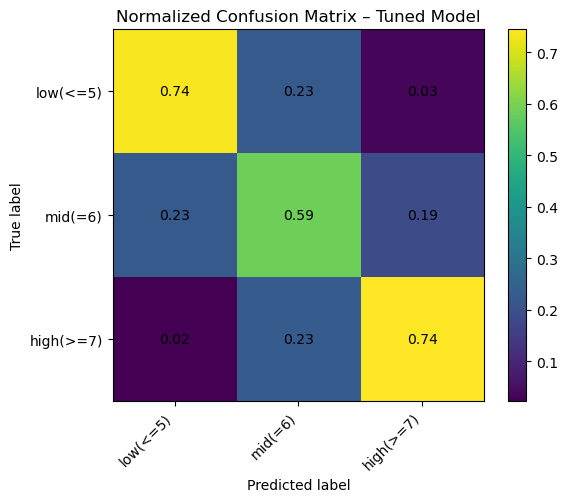

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_tune)

# Add colorbar
plt.colorbar(im, ax=ax)

# Axis labels
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Normalized Confusion Matrix – Tuned Model"
)

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate cells
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{cm_tune[i, j]:.2f}",
                ha="center", va="center")

plt.tight_layout()

plt.savefig("/Users/vanessazepeda/Documents/machine_learning/Wine-Quality/Models/ANN/ann_tuned_results/tuned_confusion_matrix.png", dpi=300)
plt.show()

In [14]:
cm_tune

array([[0.73825503, 0.22818792, 0.03355705],
       [0.2265625 , 0.5859375 , 0.1875    ],
       [0.02325581, 0.23255814, 0.74418605]])